In [1]:
! pip install tensorflow==2.3.1
! pip install keras==2.4.3


     |████████████████████████████████| 320.4 MB 20 kB/s 
     |████████████████████████████████| 2.9 MB 29.2 MB/s 
     |████████████████████████████████| 20.1 MB 11.3 MB/s 
     |████████████████████████████████| 459 kB 19.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:


  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
import os
py_file_location = "/content/drive/MyDrive/AI/WORK2/include"
sys.path.append(os.path.abspath(py_file_location))
import helpers
import IPython as IP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pickle
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

import random
# from datetime import datetime

print(keras.__version__)
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

2.3.1
2.4.0


In [4]:
tf.compat.v1.disable_v2_behavior()
# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last') # Dạng hình ảnh, cuối cùng, 30*32*1 
labels = [
    'Knock',
    'Telephone',
    'Computer_Keyboard',
    'Talking'
    ] 
# Pre-processed MFCC coefficients
X = np.load("/content/drive/MyDrive/AI/WORK2/data/X-mel.npy")
y = np.load("/content/drive/MyDrive/AI/WORK2/data/y-mel.npy")
# Metadata
metadata = pd.read_csv('/content/drive/MyDrive/AI/WORK2/data/metadata/train.csv')

#total = len(metadata)
total = X.shape[0]
indexes = list(range(0, total))
# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]

train_split_idx = indexes[split_offset:total]
# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)
# Print status
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

Instructions for updating:
non-resource variables are not supported in the long term
X test shape: (2134, 30, 32) 	 X train shape: (8537, 30, 32)
y test shape: (2134,) 		 y train shape: (8537,)


In [5]:
with open('/content/drive/MyDrive/AI/WORK2/data/parameter-mel.pickle', 'rb') as handle:
    num_rows, num_columns = pickle.load(handle)
num_channels = 1
# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
# dùng cho lớp tích chập, giảm độ phức tạp của model.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 30, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 30, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 30, 16)        64        
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 28, 30, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 28, 16)        2320      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 26, 28, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 28, 16)        6

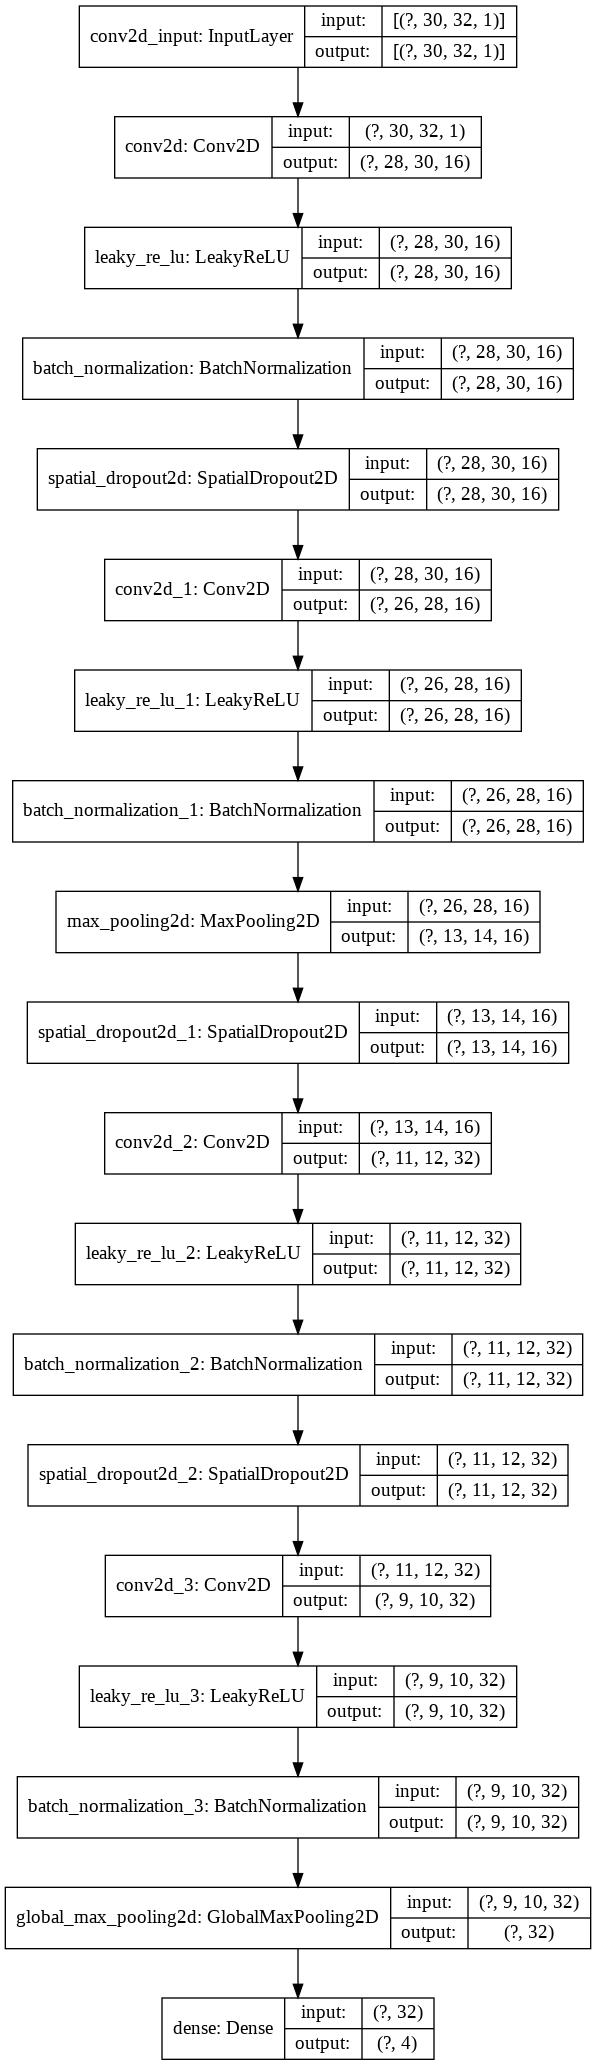

In [6]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):
        # Create a secquential object
        model = Sequential()

        # Conv 1
        model.add(Conv2D(filters=16,
                         kernel_size=(3, 3),
                         kernel_regularizer=l2(l2_rate),
                         input_shape=(num_rows, num_columns, num_channels)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())

        model.add(SpatialDropout2D(spatial_dropout_rate_1))
        model.add(Conv2D(filters=16,
                         kernel_size=(3, 3),
                         kernel_regularizer=l2(l2_rate)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())

        # Max Pooling #
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(SpatialDropout2D(spatial_dropout_rate_1))
        model.add(Conv2D(filters=32,
                         kernel_size=(3, 3),
                         kernel_regularizer=l2(l2_rate)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(SpatialDropout2D(spatial_dropout_rate_2))
        model.add(Conv2D(filters=32,
                         kernel_size=(3, 3),
                         kernel_regularizer=l2(l2_rate)))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        # Reduces each h×w feature map to a single number by taking the average of all h,w values.
        model.add(GlobalMaxPooling2D())
        # Softmax output
        model.add(Dense(num_labels, activation='softmax'))
        return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=adam)
# Display model architecture summary
model.summary()
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB'
)

In [7]:
num_epochs = 350
num_batch_size = 128
model_file = 'my_model_mel.h5'
model_path = os.path.join('/content/drive/MyDrive/AI/WORK2/models', model_file)


In [23]:
# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path,
                               verbose=1,
                               save_best_only=True)

history = model.fit(X_train,
                    y_train_encoded,
                    batch_size=num_batch_size,
                    epochs=num_epochs,
                    validation_split=1/12.,
                    callbacks=[checkpointer],
                    verbose=1) 

Train on 7825 samples, validate on 712 samples
Epoch 1/350
7680/7825 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9992
Epoch 00001: val_loss improved from inf to 0.09441, saving model to /content/drive/MyDrive/AI/WORK2/models/my_model_mel.h5
7825/7825 [==============================] - 2s 272us/sample - loss: 0.0173 - acc: 0.9992 - val_loss: 0.0944 - val_acc: 0.9789
Epoch 2/350
7552/7825 [===========================>..] - ETA: 0s - loss: 0.0199 - acc: 0.9975
Epoch 00002: val_loss did not improve from 0.09441
7825/7825 [==============================] - 1s 138us/sample - loss: 0.0197 - acc: 0.9976 - val_loss: 0.1001 - val_acc: 0.9860
Epoch 3/350
7825/7825 [==============================] - ETA: 0s - loss: 0.0174 - acc: 0.9986
Epoch 00003: val_loss did not improve from 0.09441
7825/7825 [==============================] - 1s 135us/sample - loss: 0.0174 - acc: 0.9986 - val_loss: 0.1084 - val_acc: 0.9831
Epoch 4/350
7808/7825 [============================>.] - ETA: 0s 

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0201       99.8243
Test:             0.0560       98.9222
Normal diff         64.09 


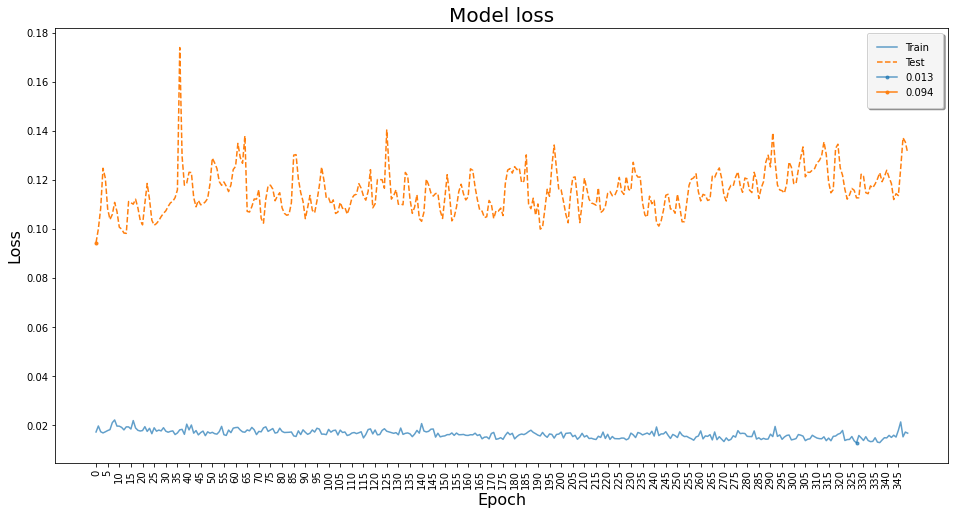

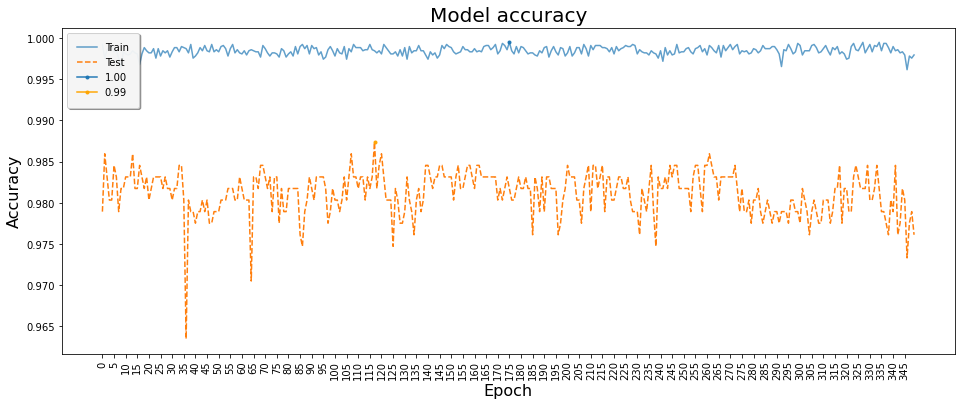

i:197, y_predicted:3, y: 1, y_prob: 0.9991803765296936
i:215, y_predicted:2, y: 0, y_prob: 0.5316761136054993
i:343, y_predicted:3, y: 0, y_prob: 0.9861534833908081
i:380, y_predicted:2, y: 3, y_prob: 0.9249071478843689
i:384, y_predicted:3, y: 2, y_prob: 0.7712851762771606
i:389, y_predicted:2, y: 0, y_prob: 0.9615808129310608
i:431, y_predicted:1, y: 3, y_prob: 0.9704020023345947
i:470, y_predicted:3, y: 0, y_prob: 0.9971197843551636
i:558, y_predicted:3, y: 1, y_prob: 0.9199824333190918
i:654, y_predicted:2, y: 1, y_prob: 0.9476557374000549
i:711, y_predicted:2, y: 3, y_prob: 0.7935056090354919
i:732, y_predicted:2, y: 3, y_prob: 0.9984051585197449
i:770, y_predicted:3, y: 1, y_prob: 0.9410006999969482
i:808, y_predicted:2, y: 3, y_prob: 0.7572924494743347
i:1532, y_predicted:0, y: 3, y_prob: 0.9882733821868896
i:1752, y_predicted:2, y: 3, y_prob: 0.9810092449188232
i:1767, y_predicted:2, y: 3, y_prob: 0.9936882853507996
i:1791, y_predicted:2, y: 0, y_prob: 0.5440073013305664
i:1834

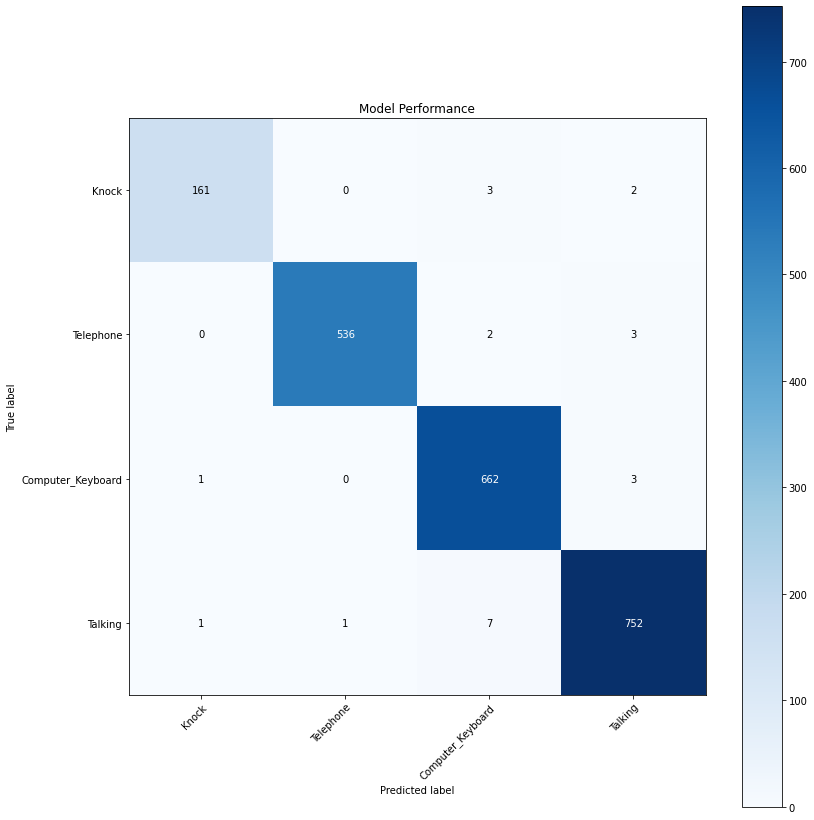

In [24]:
# Load best saved model
model = load_model(model_path)
helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)
helpers.plot_train_history(history, x_ticks_vertical=True)
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)
# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)
# Add "pred" column
#test_meta['pred'] = yhat_probs
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)
# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

count = 0
for i in range(len(y_trues)):
    if (y_trues[i] != yhat_probs[i]):
        print(f"i:{i}, y_predicted:{yhat_probs[i]}, y: {y_trues[i]}, y_prob: {y_probs[i][yhat_probs[i]]}")
        count+=1
print("count = ", count)
print("y = ", y_trues[604])
helpers.plot_confusion_matrix(cm,
                          labels,
                          normalized=False,
                          title="Model Performance",
                          cmap=plt.cm.Blues,
                          size=(12,12))